In [21]:
%load_ext autoreload
%autoreload 2
import datetime as dt
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gdal
gdal.UseExceptions()   
import ipywidgets
import ogr
import pandas as pd
from tqdm.contrib.concurrent import thread_map

import GomezEngine


ds = GomezEngine.DataStorageSentinel2LAI("http://gws-access.jasmin.ac.uk/public/odanceo/S2_LAI_v2//database.json")
print(f"Total number of acquisitions: {len(list(ds.data_db.keys())):d}")
print(f"First date: {list(ds.data_db.keys())[0].strftime('%d %b %Y'):s}")
print(f"Last date: {list(ds.data_db.keys())[-1].strftime('%d %b %Y'):s}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Total number of acquisitions: 164
First date: 01 Jan 2018
Last date: 04 Jul 2020


In [38]:
def convert(this_date, vect_ds, raster_ds):
    g = gdal.Open(raster_ds)
    gv = ogr.Open(vect_ds)
    gt = g.GetGeoTransform()
    rb = g.GetRasterBand(1)
    lyr = gv.GetLayerByIndex(0)
    li_values = list()
    
    for ii, feat in enumerate(lyr):
        geom = feat.GetGeometryRef()
        feat_id = feat.GetField('Variety')
        community = feat.GetField("Community")
        
        if geom is not None:
            mx, my = geom.GetX(), geom.GetY()

            px = int((mx - gt[0]) / gt[1])
            py = int((my - gt[3]) / gt[5])
            try:
                intval = rb.ReadAsArray(px-1, py-1, 3, 3)
            except RuntimeError:
                intval = np.ones((3,3))*np.nan
            intval = intval*1.
            intval[intval<-9000] = np.nan
            li_values.append([ii, this_date, community, feat_id, np.nanmean(intval)])
    return li_values


In [39]:

extract = lambda p: convert(
    p[0].strftime("%Y/%m/%d"),
    "locations.geojson",
    f"/vsicurl/{p[1]}")


dates = [(the_date, url) 
          for the_date, url in ds.data_db.items() 
          if the_date.year == 2018]
retval = thread_map(extract, dates)
df_2018=pd.concat([pd.DataFrame(
                x, columns=["Feature","Date","Community","Crop", "LAI"]) 
              for x in retval])
df_2018['time'] = pd.to_datetime(df_2018.Date)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


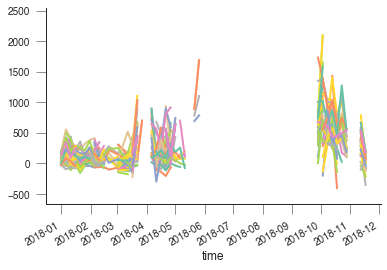

In [41]:
for nr in range(1,70):
    df_2018[df_2018.Feature==nr].plot(x="time", y="LAI", ax=plt.gca(),legend=False)


In [40]:

extract = lambda p: convert(
    p[0].strftime("%Y/%m/%d"),
    "locations.geojson",
    f"/vsicurl/{p[1]}")


dates = [(the_date, url) 
          for the_date, url in ds.data_db.items() 
          if the_date.year == 2019]
retval = thread_map(extract, dates)
df_2019=pd.concat([pd.DataFrame(
                x, columns=["Feature","Date","Community","Crop", "LAI"]) 
              for x in retval])
df_2019['time'] = pd.to_datetime(df_2019.Date)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice


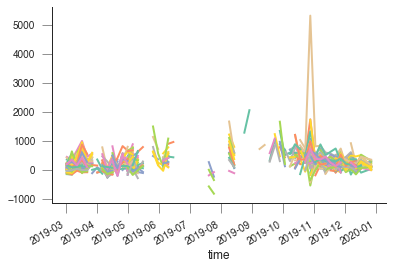

In [42]:
for nr in range(1,70):
    df_2019[df_2019.Feature==nr].plot(x="time", y="LAI", ax=plt.gca(),legend=False)
